In [13]:
import astropy.io.fits as fits
import numpy as np
from scipy.integrate import quad
import scipy.integrate as integrate
from scipy.optimize import curve_fit
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table, join
import os
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
import halomod as hm
import hmf
import treecorr

In [14]:
import DarkVerse as dv


In [15]:
home_dir = os.path.expanduser('~')
directory_SN_X3 = "/home/astro/manasoi7/Master_Thesis/Results/SN-X3"
directory_SN_C3 = "/home/astro/manasoi7/Master_Thesis/Results/SN-C3"
directory_SN_E2 = "/home/astro/manasoi7/Master_Thesis/Results/SN-E2" 
directory_COSMOS = "/home/astro/manasoi7/Master_Thesis/Results/COSMOS" 
res = os.path.join(home_dir, 'Master_Thesis', 'Results')

### re-run IC computation with fit bias value
### assign IC to self.IC_list

In [16]:
class FieldBiasEstimator:
    def __init__(self, xi_m, mask):
        """
        Initialize with matter correlation and mask that's common to all fields
        
        Parameters:
        - xi_m: np.array, matter-matter angular correlation function
        - mask: np.array, boolean mask for selecting the 2-halo term
        """
        self.xi_m = xi_m
        self.mask = mask
        self.fields = []
        
    def add_field(self, field_name, xi_g, w_theta, w_theta_error, sum_rr):
        """
        Add data for a single field
        
        Parameters:
        - field_name: str, identifier for the field
        - xi_g: np.array, galaxy-galaxy correlation for this field
        - w_theta: np.array, observed correlation function
        - w_theta_error: np.array, errors for observed correlation
        - sum_rr: np.array, RR pair counts for this field
        """
        self.fields.append({
            'name': field_name,
            'xi_g': xi_g, 
            'w_theta': w_theta,
            'w_error': w_theta_error,
            'sum_rr': sum_rr,
            'IC': None,
            'bias': None,
            'bias_error': None
        })
    
    def _calculate_IC(self, wg_no_ic, sum_rr):
        """Calculate integral constraint for given correlation and RR counts"""
        return np.sum(wg_no_ic * sum_rr) / np.sum(sum_rr)
    
    def _model(self, wdm, b, IC):
        """Model function with current IC"""
        return (wdm * b**2 - IC)[self.mask]
    
    def fit_individual_fields(self):
        """Fit bias for each field separately"""
        results = []
        for field in self.fields:
            try:
                # Initial IC estimate using xi_g
                field['IC'] = self._calculate_IC(field['xi_g'], field['sum_rr'])
                
                # Perform fit
                popt, pcov = curve_fit(
                    lambda wdm, b: self._model(wdm, b, field['IC']),
                    self.xi_m,
                    field['w_theta'][self.mask], 
                    sigma=field['w_error'][self.mask],
                    p0=[1.0],
                    maxfev=10000
                )
                
                field['bias'] = popt[0]
                field['bias_error'] = np.sqrt(np.diag(pcov))[0]
                
                # Update IC with best-fit model
                wg_no_ic_fit = self.xi_m * field['bias']**2
                field['IC'] = self._calculate_IC(wg_no_ic_fit, field['sum_rr'])
                
                results.append((field['name'], field['bias'], field['bias_error'], field['IC']))
                
            except RuntimeError:
                results.append((field['name'], np.nan, np.nan, np.nan))
        
        return results
    
    def fit_combined(self):
        """Fit combined data from all fields to get global bias"""
        if not self.fields:
            raise ValueError("No fields added for fitting")
            
        # Stack all field data
        all_w_theta = np.array([f['w_theta'][self.mask] for f in self.fields])
        all_errors = np.array([f['w_error'][self.mask] for f in self.fields])
        weights = 1.0 / (all_errors**2)
        
        # Weighted average of the observations
        combined_w = np.sum(all_w_theta * weights, axis=0) / np.sum(weights, axis=0)
        combined_err = 1.0 / np.sqrt(np.sum(1.0 / all_errors**2, axis=0))
        
        # Use mean of individual ICs as starting point
        initial_IC = np.mean([f['IC'] for f in self.fields if f['IC'] is not None])
        
        try:
            popt, pcov = curve_fit(
                lambda wdm, b: self._model(wdm, b, initial_IC),
                self.xi_m,
                combined_w,
                sigma=combined_err,
                p0=[1.0],
                maxfev=10000
            )
            
            global_bias = popt[0]
            global_error = np.sqrt(np.diag(pcov))[0]
            
            return global_bias, global_error
            
        except RuntimeError:
            return np.nan, np.nan

    def get_field_models(self, global_bias):
        models = {}
        for field in self.fields:
            if field['IC'] is not None:
                models[field['name']] = self._model(self.xi_m, global_bias, field['IC'])
            else:
                models[field['name']] = None
        return models
             
   

In [17]:
home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')

# Field details
fields = {
    "SN-X3": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-X3_zm.fits",
        "masked": "SN-X3_masked_cat.fits",
        "randoms": "SN-X3_randoms_ugriz_trim_video.fits"
    },
    "SN-C3": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-C3_zm.fits",
        "masked": "SN-C3_masked_cat.fits",
        "randoms": "SN-C3_randoms_ugriz_trim_video.fits"
    },
    "SN-E2": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-E2_zm.fits",
        "masked": "SN-E2_masked_cat.fits",
        "randoms": "SN-E2_randoms_ugriz_trim_video.fits"
    },
    "COSMOS": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_COSMOS_zm.fits",
        "masked": "COSMOS_masked_cat.fits",
        "randoms": "COSMOS_randoms_ugriz_trim_video.fits"
    }
}


# Configurations
z_min, z_max = 0.6, 0.7
SM_min, SM_max = 10.5, 11

config = {
    'min_sep': 0.003,
    'max_sep': 1.78,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'shot'
}

# Initialize the bias estimator with common matter correlation and mask
# (We'll use the first field's xi_m and mask as reference since they should be similar)
first_field = list(fields.keys())[0]
first_catalog = Table.read(os.path.join(thesis_path, fields[first_field]["catalog"]))
first_masked = Table.read(os.path.join(thesis_path, fields[first_field]["masked"]))
first_catalog = join(first_catalog, first_masked, keys='id')
first_catalog.rename_columns(['ra_1', 'dec_1'], ['ra', 'dec'])
first_randoms = Table.read(os.path.join(thesis_path, fields[first_field]["randoms"]))

first_subsample = dv.Subsample(catalog=first_catalog, randoms=first_randoms,
                             z_min=z_min, z_max=z_max,
                             SM_min=SM_min, SM_max=SM_max,
                             config=config)
first_results = first_subsample.get_results()

# Initialize estimator with matter correlation and mask that's common to all fields
estimator = FieldBiasEstimator(
    xi_m=np.array(first_results['xi_m']),
    mask=(np.array(first_results['theta']) >= 0.1) & (np.array(first_results['theta']) <= 0.4)
)

# Process each field
for field, paths in fields.items():
    print(f"\n🔹 Processing field: {field}")
    
    # Load data
    catalog = Table.read(os.path.join(thesis_path, paths["catalog"]))
    masked = Table.read(os.path.join(thesis_path, paths["masked"]))
    catalog = join(catalog, masked, keys='id')
    catalog.rename_columns(['ra_1', 'dec_1'], ['ra', 'dec'])
    randoms = Table.read(os.path.join(thesis_path, paths["randoms"]))

    # Compute subsample
    subsample = dv.Subsample(catalog=catalog, randoms=randoms,
                           z_min=z_min, z_max=z_max,
                           SM_min=SM_min, SM_max=SM_max,
                           config=config)
    results = subsample.get_results()

    # Add field data to estimator
    estimator.add_field(
        field_name=field,
        xi_g=np.array(results['xi_g']),
        w_theta=np.array(results['w_theta']),
        w_theta_error=np.sqrt(np.array(results['var_w_theta_bootstrap'])),
        sum_rr=np.array(results['rr_counts'])
    )

# 1. Fit individual fields and print results
print("\nIndividual Field Results:")
individual_results = estimator.fit_individual_fields()
for name, b, be, ic in individual_results:
    print(f"{name}: b = {b:.3f} ± {be:.3f}, IC = {ic:.4f}")

# 2. Get combined bias estimate
global_b, global_be = estimator.fit_combined()
print(f"\nGlobal bias estimate: {global_b:.3f} ± {global_be:.3f}")

# 3. Get field-specific models using global bias
field_models = estimator.get_field_models(global_b)



The following patch numbers have no objects: {29}
This may be a problem depending on your use case.
The following patch numbers have no objects: {23}
This may be a problem depending on your use case.
The following patch numbers have no objects: {29}
This may be a problem depending on your use case.


/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/hmf/density_field/transfer_models.py:233: UserWarning: 'extrapolate_with_eh' was not set. Defaulting to True, which is different behaviour than versions <=3.4.4. This warning may be removed in v4.0. Silence it by setting extrapolate_with_eh explicitly.
  warnings.warn(
/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/halomod/halo_model.py:784: UserWarning: You are using an un-normalized mass function and bias function pair.Bias Tinker10 has the following paired HMF model: (). Matter correlations are not well-defined.
  tools.norm_warn(self)



🔹 Processing field: SN-X3
The following patch numbers have no objects: {29}
This may be a problem depending on your use case.
The following patch numbers have no objects: {30}
This may be a problem depending on your use case.

🔹 Processing field: SN-C3
The following patch numbers have no objects: {38}
This may be a problem depending on your use case.
The following patch numbers have no objects: {42}
This may be a problem depending on your use case.
The following patch numbers have no objects: {25}
This may be a problem depending on your use case.
The following patch numbers have no objects: {38}
This may be a problem depending on your use case.
The following patch numbers have no objects: {39}
This may be a problem depending on your use case.
The following patch numbers have no objects: {39}
This may be a problem depending on your use case.

🔹 Processing field: SN-E2
The following patch numbers have no objects: {10}
This may be a problem depending on your use case.
The following patch

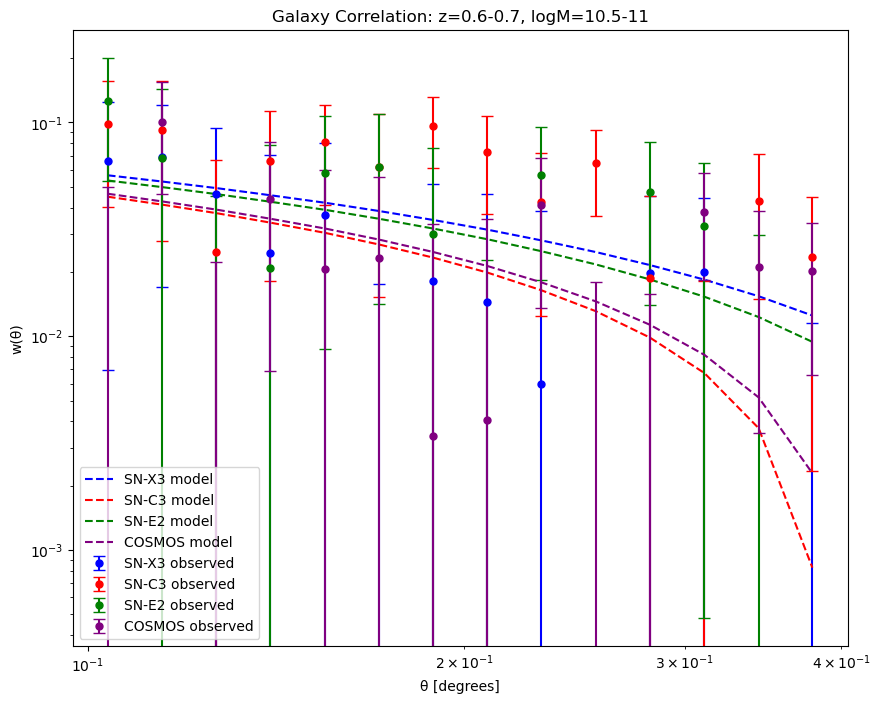

In [34]:
colors = {"SN-X3": "blue", "SN-C3": "red", "SN-E2": "green", "COSMOS": "purple"}

plt.figure(figsize=(10, 8))

theta = np.array(first_results['theta'])  # Using first field's theta as reference

for field_data in estimator.fields:
    field_name = field_data['name']
    if field_name in field_models and field_models[field_name] is not None:
        # Plot observed data
        plt.errorbar(
            theta[estimator.mask],
            field_data['w_theta'][estimator.mask],
            yerr=field_data['w_error'][estimator.mask],
            fmt='o', color=colors.get(field_name, 'black'),
             capsize=4, markersize=5, 
            label=f'{field_name} observed'
        )
        
        # Plot model
        plt.plot(
            theta[estimator.mask],
            field_models[field_name],
            color=colors.get(field_name, 'black'), 
            linestyle='--', 
            label=f'{field_name} model '
        )

plt.xscale('log')
plt.yscale('log')
plt.xlabel('θ [degrees]')
plt.ylabel('w(θ)')
plt.title(f'Galaxy Correlation: z={z_min}-{z_max}, logM={SM_min}-{SM_max}')
plt.legend()
plt.show()

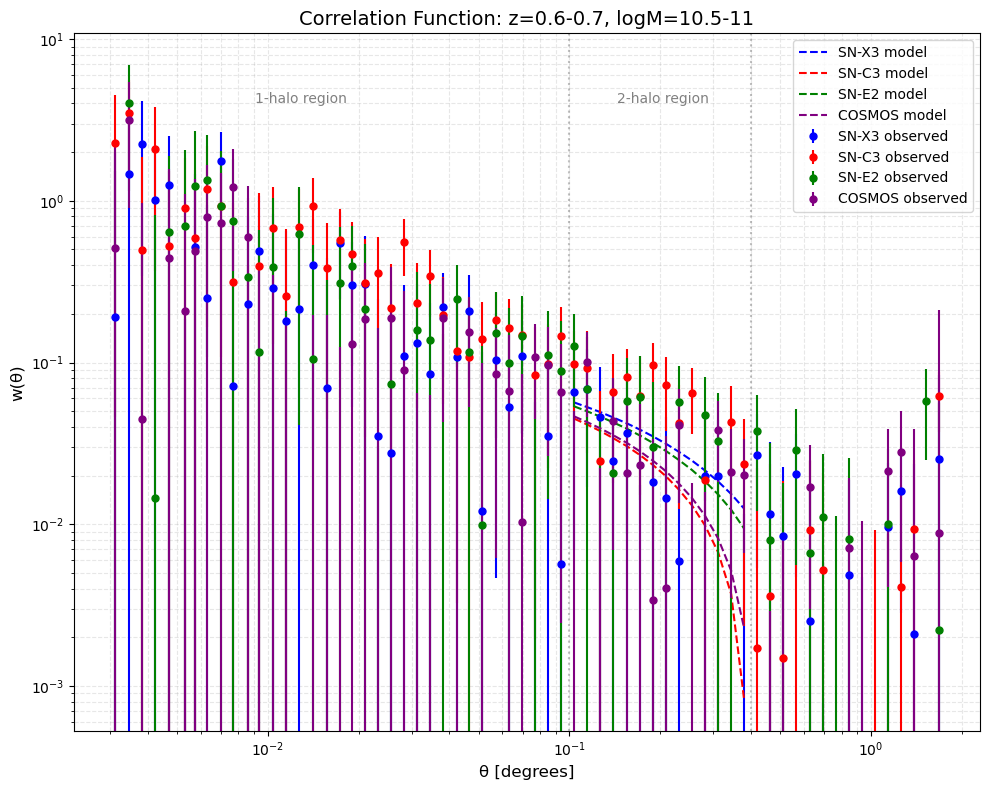

In [60]:

plt.figure(figsize=(10, 8))

for field_data in estimator.fields:
    field_name = field_data['name']
    if field_name in field_models and field_models[field_name] is not None:
        # Plot FULL observed data (not just masked region)
        plt.errorbar(
            theta,
            field_data['w_theta'],
            yerr=field_data['w_error'],
            fmt='o', color=colors.get(field_name, 'black'),
            markersize=5,
            label=f'{field_name} observed'
        )
        
        # Create full-range model (we need to reconstruct this)
        #full_wdm = field_data['xi_m']  # Matter correlation
        #full_IC = field_data['IC']     # Field-specific IC
        #full_model = full_wdm * global_b**2 - full_IC
        
        # Plot model
        plt.plot(
            theta[estimator.mask],
            field_models[field_name],
            color=colors.get(field_name, 'black'), 
            linestyle='--', 
            label=f'{field_name} model '
        )

# Add reference lines
plt.axvline(0.1, color='gray', linestyle=':', alpha=0.5)  # Show original mask boundary
plt.axvline(0.4, color='gray', linestyle=':', alpha=0.5)

# Formatting
plt.xscale('log')
plt.yscale('log')
plt.xlabel('θ [degrees]', fontsize=12)
plt.ylabel('w(θ)', fontsize=12)
plt.title(f'Correlation Function: z={z_min}-{z_max}, logM={SM_min}-{SM_max}', fontsize=14)
plt.legend(fontsize=10, framealpha=0.8)
plt.grid(True, which="both", ls="--", alpha=0.3)

# Add annotations
plt.text(0.2, 0.9, "1-halo region", transform=plt.gca().transAxes, color='gray')
plt.text(0.6, 0.9, "2-halo region", transform=plt.gca().transAxes, color='gray')


plt.tight_layout()
plt.show()

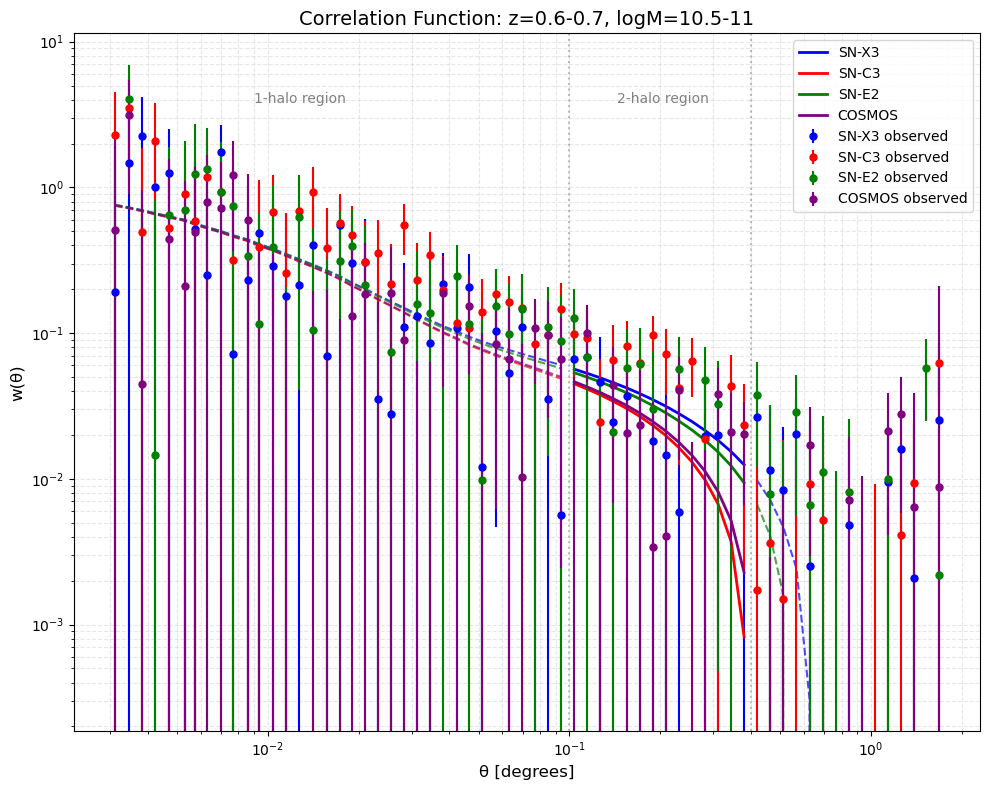

In [73]:
plt.figure(figsize=(10, 8))

for field_data in estimator.fields:
    field_name = field_data['name']
    if field_name in field_models and field_models[field_name] is not None:
        
        # Get theta values (using first field as reference)
        theta = np.array(first_results['theta'])
        
        # Plot observed data points
        plt.errorbar(
            theta,
            field_data['w_theta'],
            yerr=field_data['w_error'],
            fmt='o', 
            color=colors.get(field_name, 'black'),
            markersize=5,
            label=f'{field_name} observed'
        )
        
        # Reconstruct full model
        full_wdm = np.array(first_results['xi_m'])
        full_IC = field_data['IC']
        full_model = full_wdm * global_b**2 - full_IC
        
        # Create masks for different regions
        two_halo_mask = (theta >= 0.1) & (theta <= 0.4)  # 2-halo region
        one_halo_mask = theta < 0.1                      # 1-halo region
        extended_mask = theta > 0.4                      # Extended 2-halo
        
        # Plot 2-halo region (solid line)
        plt.plot(
            theta[two_halo_mask],
            full_model[two_halo_mask],
            color=colors.get(field_name, 'black'),
            linestyle='-',
            linewidth=2,label=f'{field_name}')
            #label=f'{field_name} model (b={global_b:.2f})' if field_name == list(fields.keys())[0] else ""
            # Only label for first field to avoid duplicate legends)
        
        # Plot 1-halo region (dashed line)
        plt.plot(
            theta[one_halo_mask],
            full_model[one_halo_mask],
            color=colors.get(field_name, 'black'),
            linestyle='--',
            linewidth=1.5,
            alpha=0.7
        )
        
        # Plot extended 2-halo region (dashed line)
        plt.plot(
            theta[extended_mask],
            full_model[extended_mask],
            color=colors.get(field_name, 'black'),
            linestyle='--',
            linewidth=1.5,
            alpha=0.7
        )

# Add reference lines and annotations
plt.axvline(0.1, color='gray', linestyle=':', alpha=0.5)  
plt.axvline(0.4, color='gray', linestyle=':', alpha=0.5)

# Formatting
plt.xscale('log')
plt.yscale('log')
plt.xlabel('θ [degrees]', fontsize=12)
plt.ylabel('w(θ)', fontsize=12)
plt.title(f'Correlation Function: z={z_min}-{z_max}, logM={SM_min}-{SM_max}', fontsize=14)

# Improved legend handling
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Remove duplicates
plt.legend(by_label.values(), by_label.keys(), fontsize=10, framealpha=0.8)

plt.grid(True, which="both", ls="--", alpha=0.3)

# Annotations (1-halo is smaller scales)
plt.text(0.25, 0.9, "1-halo region", transform=plt.gca().transAxes, color='gray', ha='center')
plt.text(0.65, 0.9, "2-halo region", transform=plt.gca().transAxes, color='gray', ha='center')

plt.savefig(os.path.join(res, 'b-4fields-highSM'))


plt.tight_layout()
plt.show()